In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4.0, 0.5) 
import matplotlib.patches as mpathes

# load color descriptors and values

color label to pytorch tensor, only mean vector of the samples are used

In [2]:
cdict = {}
basedir = "./xkcd_colordata/"
for cfile in os.listdir(basedir):
    if cfile.endswith(".train") or cfile.endswith(".dev"):
        cname = cfile[:cfile.find(".")]
        with open(basedir+cfile,"rb") as f:
            all_smaples = np.array(pickle.load(f)) / 255   # normalized to [0,1]
            cdict[cname] = torch.FloatTensor(all_smaples.mean(axis=0))

In [3]:
cdict["blue"]

tensor([0.2091, 0.3767, 0.7748])

single word label to multi-word descriptions

In [4]:
label2words = {}
with open("words_to_labels.txt",encoding="utf-8") as f:
    for line in f:
        words, label = line.strip().split(',')
        label2words[label] = words

In [5]:
label2words["lightblue"]

'light blue'

extract triples like `('blueviolet', ('bluer',), 'violet')`

In [6]:
to_compara = dict(line.strip().split(":") for line in open("comparatives.txt", encoding="utf-8"))
to_more_quanti = dict(line.strip().split(":") for line in open("quantifiers.txt", encoding="utf-8"))

triples = []
for label in cdict:
    words = label2words[label].split()
    if len(words) > 1:
        quantifier, base = words[0], "".join(words[1:])
        if base in cdict:
            if quantifier in to_compara:        # uni-gram('lighter',)
                triples.append((label, (to_compara[quantifier],), base))
            elif quantifier in to_more_quanti:  # bigram('more','bluish')
                triples.append((label, ("more", to_more_quanti[quantifier]), base))

In [7]:
triples[:5]

[('acidgreen', ('more', 'acidic'), 'green'),
 ('blueviolet', ('bluer',), 'violet'),
 ('blueygreen', ('bluer',), 'green'),
 ('blueypurple', ('bluer',), 'purple'),
 ('bluishgreen', ('more', 'bluish'), 'green')]

In [8]:
# pre-extracted subset of https://www.kaggle.com/yekenot/fasttext-crawl-300d-2m
with open("embeddings.pickle","rb") as f:
    embeddings = pickle.load(f)

In [9]:
len(embeddings)

357

# Training

In [10]:
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        self.fc1 = nn.Linear(603,30)
        self.fc2 = nn.Linear(33,3)
    def forward(self, emb1, emb2, source_color):
        x1 = self.fc1(torch.cat([emb1, emb2, source_color]))
        wg = self.fc2(torch.cat([x1,source_color]))
        return wg

In [11]:
mse = nn.MSELoss()
cos = nn.CosineSimilarity(dim=0)
my_loss = lambda source, target, wg: (1-cos(wg, target-source)) + mse(target, source+wg)

In [12]:
epoches = 800
net = ColorNet()
optimizer = optim.Adam(net.parameters(), lr=0.001)
for i in range(epoches):
    loss = 0
    for target_str, comp_words, source_str in triples:
        if len(comp_words) == 1:
            emb1, emb2 = torch.zeros(300,), torch.from_numpy(embeddings[comp_words[0]])
        else:
            emb1, emb2 = torch.from_numpy(embeddings[comp_words[0]]), torch.from_numpy(embeddings[comp_words[1]])
        emb1, emb2 = torch.FloatTensor(emb1), torch.FloatTensor(emb2)
        target, source = cdict[target_str], cdict[source_str]
        wg = net(emb1, emb2, source)
        loss += my_loss(source, target, wg)
    if i % 50 == 0:
        print(f"step:{i}, loss:{loss.detach().numpy()}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

step:0, loss:281.0379943847656
step:50, loss:51.73341751098633
step:100, loss:45.4268684387207
step:150, loss:44.92023468017578
step:200, loss:39.38445281982422
step:250, loss:37.8366584777832
step:300, loss:37.3712158203125
step:350, loss:39.405025482177734
step:400, loss:37.89094543457031
step:450, loss:37.310089111328125
step:500, loss:36.994022369384766
step:550, loss:36.575469970703125
step:600, loss:36.40888214111328
step:650, loss:36.22138977050781
step:700, loss:36.5299072265625
step:750, loss:37.493202209472656


# Testing

In [13]:
def get_compara_direction(compara, source_str):
    '''
    compara: comparative color descriptions like `lighter`
    source_str: source color like `blue`
    '''
    comp_words = compara.split()
    if len(comp_words) == 1:
        emb1, emb2 = torch.zeros(300,), torch.from_numpy(embeddings[comp_words[0]])
    else:
        emb1, emb2 = torch.from_numpy(embeddings[comp_words[0]]), torch.from_numpy(embeddings[comp_words[1]])
    emb1, emb2 = torch.FloatTensor(emb1), torch.FloatTensor(emb2)
    source = cdict[source_str]
    wg = net(emb1, emb2, source)
    return wg.detach().numpy()

In [14]:
get_compara_direction("lighter","purple")

array([0.08290963, 0.15813543, 0.07795188], dtype=float32)

In [15]:
get_compara_direction("darker","purple")

array([-0.07854243, -0.04148286, -0.10587399], dtype=float32)

In [16]:
get_compara_direction("lighter","blue")

array([0.12483665, 0.12858301, 0.06017698], dtype=float32)

In [17]:
get_compara_direction("more blueish","purple")

array([-0.09904111,  0.07201194,  0.15063742], dtype=float32)

In [18]:
get_compara_direction("more blueish","black")

array([-0.05477055,  0.0819556 ,  0.24324164], dtype=float32)

In [24]:
def plot_color_change(compara, source_str, strength=1, save_path=None):
    '''
    compara: comparative color descriptions like `lighter`
    source_str: source color like `blue`
    strength: the ratio of exaggerating the effect to make it more perceivable
    '''
    ax = plt.gca()
    source = cdict[source_str].detach().numpy()
    direction = get_compara_direction(compara, source_str)
    ax = plt.gca()
    N = 100
    width, height = 1, 1
    for x in np.linspace(0, width, N):
        ax.add_patch(mpathes.Rectangle([x,0],width/N,height,color=np.clip(source+direction*x*strength,0,1)))
    plt.axis('off')
    if save_path:
        plt.savefig(save_path)
    plt.show()

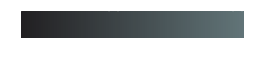

In [25]:
plot_color_change("lighter", "black", strength=2)

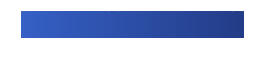

In [28]:
plot_color_change("darker", "blue",2,'./imgs/darker_blue.png')

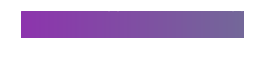

In [29]:
plot_color_change("more electric", "purple",1 ,'./imgs/more_electric_purple.png')